# Importing Data

In [347]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers;

In [2]:
digits_train = pd.read_csv("train.csv")
digits_test = pd.read_csv("test.csv")

In [3]:
digits_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Explorarary Data Analysis

## Structure of Data

In [74]:
digits_train.shape

(42000, 785)

Training dataset:
-  28x28 image in 784 columns and 1 label
- 42000 images

In [7]:
digits_test.shape

(28000, 784)

Test dataset:
- 28x28 image in 784 columns
- 28000 images

In [81]:
X_test = digits_test

In [110]:
X_train, y_train = digits_train.iloc[:,1:], digits_train["label"]

## Null values

In [111]:
digits_train.isna().sum().describe()

count    785.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

There are no null values

## Visualize the images

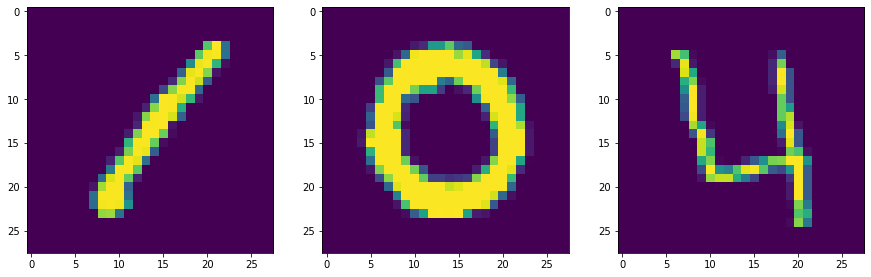

In [112]:
#Let's check how few images look like
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(np.array(X_train.iloc[0]).reshape(28,28))
ax[1].imshow(np.array(X_train.iloc[1]).reshape(28,28))
ax[2].imshow(np.array(X_train.iloc[3]).reshape(28,28));

## Distribution of Image labels

In [113]:
y_counts = y_train.value_counts(sort = True, normalize = True)
digits_train.groupby("label").agg({"label":"count"})

,label
label,
0,4132
1,4684
2,4177
3,4351
4,4072
5,3795
6,4137
7,4401
8,4063


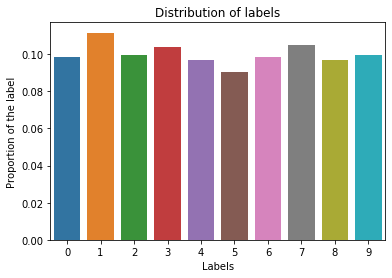

In [114]:
plt.figure(figsize = (6,4))
ax = sns.barplot(x=y_counts.index, y = y_counts.values)
ax.set_title("Distribution of labels")
ax.set_ylabel("Proportion of the label")
ax.set_xlabel("Labels");

We observe the labels are fairly evenly distributed

Divide the data into train and validation sets before modeling

# Data Engineering / Wrangling

## Normalizing
Neural networks converge faster for normalized data. The data has max 255 represeting the brightness of the image

In [115]:
X_train = X_train / 255
X_test = X_test / 255

## Converting labels to categorical outputs

In [116]:
y_train = to_categorical(y_train, num_classes = 10)

## Splitting the training data
- training set
- test set

We do not have labels for the test set provided on Kaggle. Hence, we test on them later

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

## Reshaping data for use in CNN
- Length x width = 28X28
- Channel = 1

In [180]:
X_train_r, X_test_r = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)

# Modeling

In [185]:
Summary_table = pd.DataFrame(columns = ["model", "Test accuracy"])

## Logistic Regression
Baseline model for comparison 

In [188]:
lr = LogisticRegression(max_iter = 1000)

In [189]:
lr.fit(X_train, np.argmax(y_train, axis = 1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [191]:
test_accuracy = lr.score(X_test, np.argmax(y_test, axis = 1))

In [194]:
Summary_table  = Summary_table.append({"model": "Logistic Regression", "Test accuracy": test_accuracy }, ignore_index = True)

In [195]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708


## Shallow fully connected Neural Network
- Hidden layer1: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations

In [196]:
model_s = Sequential()
model_s.add(Dense(5, input_shape = (784,), activation = "relu"))
#Output layer
model_s.add(Dense(10, activation = "softmax"))
model_s.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [197]:
model_s.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


There are:
- Layer1: Weights =  784*5, Bias(each node's) = 5. Total = 3925
- Layer2 (output): Weights = 5*10 = 50, Bias (each node's) = 10. Total 60

Toatal parameters = 3985

In [200]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10)

In [201]:
history = model_s.fit(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [early_stopping])

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 1s 40us/step - loss: 0.3151 - accuracy: 0.9104 - val_loss: 0.3975 - val_accuracy: 0.8884
Epoch 2/100
21504/21504 [==============================] - 1s 41us/step - loss: 0.3146 - accuracy: 0.9102 - val_loss: 0.3983 - val_accuracy: 0.8878
Epoch 3/100
21504/21504 [==============================] - 1s 42us/step - loss: 0.3142 - accuracy: 0.9088 - val_loss: 0.3968 - val_accuracy: 0.8895
Epoch 4/100
21504/21504 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9108 ETA: 0s - l - 1s 42us/step - loss: 0.3121 - accuracy: 0.9107 - val_loss: 0.3976 - val_accuracy: 0.8878
Epoch 5/100
21504/21504 [==============================] - 1s 41us/step - loss: 0.3112 - accuracy: 0.9095 - val_loss: 0.3978 - val_accuracy: 0.8906
Epoch 6/100
21504/21504 [==============================] - 1s 44us/step - loss: 0.3113 - accuracy: 0.9102 - val_loss: 0.4004 - val_accuracy: 0.8897
Epoch 7

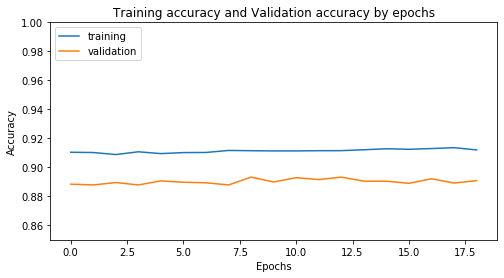

In [202]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.85,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [207]:
test_accuracy = model_s.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 26us/step


In [208]:
Summary_table  = Summary_table.append({"model": "Shallow NN", "Test accuracy": test_accuracy }, ignore_index = True)

Observation:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.09
- Test accuracy: 0.12

Therefore, we can focus on trying to decrease the gap between bayes error and training error with **more complex model**


## Fully connected 2 HL Neural Network 
- Hidden layer1: 5 nodes, activation function: relu
- Hidden layer2: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations
- Batch Normalization before every layer

In [216]:
model_fc = Sequential()
model_fc.add(Dense(5, input_shape = (784,), activation = "relu"))
model_fc.add(BatchNormalization())
model_fc.add(Dense(5, activation = "relu"))
model_fc.add(BatchNormalization())
model_fc.add(Dense(10, activation = "softmax"))

In [217]:
model_fc.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics =["accuracy"])

In [218]:
model_fc.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 5)                 3925      
_________________________________________________________________
batch_normalization_3 (Batch (None, 5)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 30        
_________________________________________________________________
batch_normalization_4 (Batch (None, 5)                 20        
_________________________________________________________________
dense_15 (Dense)             (None, 10)                60        
Total params: 4,055
Trainable params: 4,035
Non-trainable params: 20
_________________________________________________________________


In [220]:
history = model_fc.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping], epochs = 100)

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 4s 199us/step - loss: 0.9192 - accuracy: 0.7074 - val_loss: 0.7317 - val_accuracy: 0.7731
Epoch 2/100
21504/21504 [==============================] - 3s 138us/step - loss: 0.7038 - accuracy: 0.7816 - val_loss: 0.5997 - val_accuracy: 0.8144
Epoch 3/100
21504/21504 [==============================] - 3s 139us/step - loss: 0.6129 - accuracy: 0.8146 - val_loss: 0.5449 - val_accuracy: 0.8348
Epoch 4/100
21504/21504 [==============================] - 3s 117us/step - loss: 0.5561 - accuracy: 0.8329 - val_loss: 0.5275 - val_accuracy: 0.8438
Epoch 5/100
21504/21504 [==============================] - 3s 118us/step - loss: 0.5296 - accuracy: 0.8392 - val_loss: 0.4716 - val_accuracy: 0.8618
Epoch 6/100
21504/21504 [==============================] - 3s 117us/step - loss: 0.5113 - accuracy: 0.8455 - val_loss: 0.4768 - val_accuracy: 0.8592
Epoch 7/100
21504/21504 [==============================] 

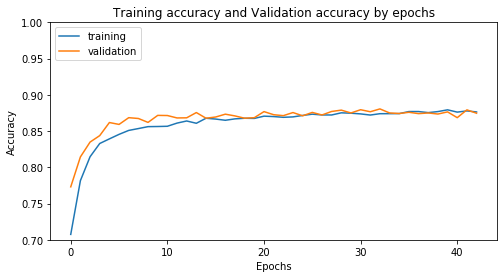

In [222]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.7,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [238]:
test_accuracy = model_fc.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 35us/step


In [239]:
Summary_table  = Summary_table.append({"model": "NN 2 HL,5 nodes", "Test accuracy": test_accuracy }, ignore_index = True)

Observations: <br>
Increasing  a layer has actually decrased the accuracy rather than increasing. The network needs more width

## Fully Connected 2 HL Neural Network (16 nodes)
- Hidden layer1: 16 nodes, activation function: relu
- Hidden layer2: 16 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations
- Batch Normalization before every layer

In [226]:
model_fc16 = Sequential()
model_fc16.add(Dense(16, input_shape = (784,), activation = "relu"))
model_fc16.add(BatchNormalization())
model_fc16.add(Dense(16, activation = "relu"))
model_fc16.add(BatchNormalization())
model_fc16.add(Dense(10, activation = "softmax"))

In [227]:
model_fc16.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [228]:
model_fc16.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                12560     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)                64        
_________________________________________________________________
dense_20 (Dense)             (None, 10)                170       
Total params: 13,130
Trainable params: 13,066
Non-trainable params: 64
_________________________________________________________________


In [230]:
history = model_fc16.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 3s 150us/step - loss: 0.7792 - accuracy: 0.7835 - val_loss: 0.3735 - val_accuracy: 0.8951
Epoch 2/100
21504/21504 [==============================] - 5s 221us/step - loss: 0.3479 - accuracy: 0.8990 - val_loss: 0.2872 - val_accuracy: 0.9174
Epoch 3/100
21504/21504 [==============================] - 4s 165us/step - loss: 0.2841 - accuracy: 0.9150 - val_loss: 0.2450 - val_accuracy: 0.9267
Epoch 4/100
21504/21504 [==============================] - 6s 273us/step - loss: 0.2585 - accuracy: 0.9251 - val_loss: 0.2440 - val_accuracy: 0.9280
Epoch 5/100
21504/21504 [==============================] - 5s 238us/step - loss: 0.2319 - accuracy: 0.9303 - val_loss: 0.2261 - val_accuracy: 0.9330
Epoch 6/100
21504/21504 [==============================] - 5s 234us/step - loss: 0.2191 - accuracy: 0.9323 - val_loss: 0.2149 - val_accuracy: 0.9362
Epoch 7/100
21504/21504 [==============================] 

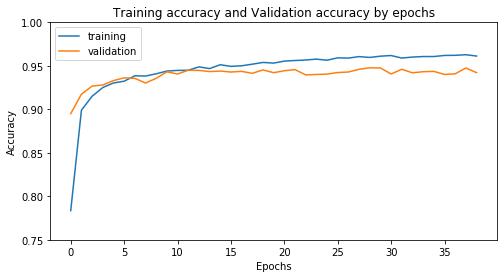

In [232]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.75,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [240]:
test_accuracy = model_fc16.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 41us/step


In [241]:
Summary_table  = Summary_table.append({"model": "NN 2 HL,16 nodes", "Test accuracy": test_accuracy }, ignore_index = True)

In [243]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708
1,Shallow NN,0.884673
2,"NN 2 HL,5 nodes",0.875595
3,"NN 2 HL,16 nodes",0.939435


Observations:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.04
- Test accuracy: 0.06

We have successfully reduced the bias but there still is 0.04 reducable bias which can be tackled with **more complex model**

## Optimizing Fully Connected Neural Network
Based on our observation so far, we can optimize the neural network with hyperparamters tuning:
- Optimizer: Stochastic Gradient Descent and Adam
- Nodes: 16, 32, 64, 128
- Hidden Layers: 2,3,4
- Activation function: relu, tanh

In [274]:
def create_model(optimizer ="adam", hl = 2, nodes = 16, activation = "relu"):
    model = Sequential()
    model.add(Dense(nodes, input_shape = (784,), activation = activation))
    l=1
    while(l < hl):
        model.add(Dense(nodes,activation = activation))
        model.add(BatchNormalization())
        l+=1
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy",metrics = ["accuracy"])
    return model

In [288]:
NN_parameters = {"optimizer":["sgd", "adam"], "hl":[2,3,4], "nodes":[16,32,64,128], "activation":["relu","tanh"]}

In [291]:
model = KerasClassifier(build_fn = create_model, epochs = 10)

In [294]:
RS_CV = RandomizedSearchCV(model, n_iter = 10, param_distributions = NN_parameters, cv = 3)

In [295]:
RS_CV.fit(X_train, y_train)

Epoch 1/10
17920/17920 [==============================] - 3s 194us/step - loss: 0.3534 - accuracy: 0.8921
Epoch 2/10
17920/17920 [==============================] - 1s 76us/step - loss: 0.1902 - accuracy: 0.9422
Epoch 3/10
17920/17920 [==============================] - 1s 76us/step - loss: 0.1380 - accuracy: 0.9559
Epoch 4/10
17920/17920 [==============================] - 1s 75us/step - loss: 0.1062 - accuracy: 0.9658
Epoch 5/10
17920/17920 [==============================] - 1s 75us/step - loss: 0.0923 - accuracy: 0.9715
Epoch 6/10
17920/17920 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - 1s 80us/step - loss: 0.0773 - accuracy: 0.9753
Epoch 7/10
17920/17920 [==============================] - 1s 83us/step - loss: 0.0627 - accuracy: 0.9792
Epoch 8/10
17920/17920 [==============================] - 2s 84us/step - loss: 0.0603 - accuracy: 0.9802
Epoch 9/10
17920/17920 [==============================] - 1s 83us/step - loss: 0.0488 - accuracy: 0.9835
Epoch 10/10


17920/17920 [==============================] - 1s 45us/step - loss: 0.2577 - accuracy: 0.9239
Epoch 4/10
17920/17920 [==============================] - 1s 44us/step - loss: 0.2212 - accuracy: 0.9366 0s - loss: 0.2250 - accuracy: 
Epoch 5/10
17920/17920 [==============================] - 1s 44us/step - loss: 0.1994 - accuracy: 0.9422 0s - loss: 0.1989 - accuracy: 
Epoch 6/10
17920/17920 [==============================] - 1s 44us/step - loss: 0.1828 - accuracy: 0.9454
Epoch 7/10
17920/17920 [==============================] - 1s 44us/step - loss: 0.1658 - accuracy: 0.9498
Epoch 8/10
17920/17920 [==============================] - 1s 44us/step - loss: 0.1586 - accuracy: 0.9529
Epoch 9/10
17920/17920 [==============================] - 1s 44us/step - loss: 0.1484 - accuracy: 0.9555
Epoch 10/10
8960/8960 [==============================] - 0s 21us/step
Epoch 1/10
17920/17920 [==============================] - 1s 52us/step - loss: 0.8061 - accuracy: 0.7713
Epoch 2/10
17920/17920 [===============

17920/17920 [==============================] - 1s 57us/step - loss: 0.2469 - accuracy: 0.9265
Epoch 3/10
17920/17920 [==============================] - 1s 55us/step - loss: 0.1797 - accuracy: 0.9469
Epoch 4/10
17920/17920 [==============================] - 1s 56us/step - loss: 0.1492 - accuracy: 0.9539
Epoch 5/10
17920/17920 [==============================] - 1s 55us/step - loss: 0.1235 - accuracy: 0.9613
Epoch 6/10
17920/17920 [==============================] - 1s 56us/step - loss: 0.1164 - accuracy: 0.9641
Epoch 7/10
17920/17920 [==============================] - 1s 55us/step - loss: 0.0964 - accuracy: 0.9695
Epoch 8/10
17920/17920 [==============================] - 1s 56us/step - loss: 0.0858 - accuracy: 0.9727 0s -
Epoch 9/10
17920/17920 [==============================] - 1s 54us/step - loss: 0.0722 - accuracy: 0.9771
Epoch 10/10
8960/8960 [==============================] - 0s 26us/step
Epoch 1/10
17920/17920 [==============================] - 1s 72us/step - loss: 1.0260 - accuracy

17920/17920 [==============================] - 1s 70us/step - loss: 0.1476 - accuracy: 0.9533
Epoch 4/10
17920/17920 [==============================] - 1s 69us/step - loss: 0.1124 - accuracy: 0.9644
Epoch 5/10
17920/17920 [==============================] - 1s 69us/step - loss: 0.1018 - accuracy: 0.9675 0s - loss: 0.1014 - accuracy: 0.
Epoch 6/10
17920/17920 [==============================] - 1s 69us/step - loss: 0.0771 - accuracy: 0.9759 0s - loss: 0
Epoch 7/10
17920/17920 [==============================] - 1s 69us/step - loss: 0.0710 - accuracy: 0.9770 0s - loss: 0.069
Epoch 8/10
17920/17920 [==============================] - 1s 70us/step - loss: 0.0619 - accuracy: 0.9798
Epoch 9/10
17920/17920 [==============================] - 1s 69us/step - loss: 0.0551 - accuracy: 0.9822
Epoch 10/10
8960/8960 [==============================] - 0s 27us/step
Epoch 1/10
17920/17920 [==============================] - 1s 82us/step - loss: 0.4612 - accuracy: 0.8604
Epoch 2/10
17920/17920 [==============

Epoch 4/10
17920/17920 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.92 - 1s 62us/step - loss: 0.2675 - accuracy: 0.9221
Epoch 5/10
17920/17920 [==============================] - 1s 62us/step - loss: 0.2416 - accuracy: 0.9294
Epoch 6/10
17920/17920 [==============================] - 1s 61us/step - loss: 0.2152 - accuracy: 0.9376 0s - l
Epoch 7/10
17920/17920 [==============================] - 1s 61us/step - loss: 0.1976 - accuracy: 0.9432
Epoch 8/10
17920/17920 [==============================] - 1s 62us/step - loss: 0.1758 - accuracy: 0.9485 0s - los
Epoch 9/10
17920/17920 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.95 - 1s 62us/step - loss: 0.1631 - accuracy: 0.9542
Epoch 10/10
8960/8960 [==============================] - 0s 27us/step
Epoch 1/10
17920/17920 [==============================] - 1s 66us/step - loss: 0.5551 - accuracy: 0.8354 0s - loss: 0.663
Epoch 2/10
17920/17920 [==============================] - 1s 61us/step - loss:

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000027A4EB19408>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'hl': [2, 3, 4],
                                        'nodes': [16, 32, 64, 128],
                                        'optimizer': ['sgd', 'adam']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [296]:
RS_CV.best_params_

{'optimizer': 'adam', 'nodes': 128, 'hl': 3, 'activation': 'tanh'}

Best parameters:
- Optimizer: adam
- 3 hidden layers
- Activation tanh

In [303]:
RS_CV.best_params_

{'optimizer': 'adam', 'nodes': 128, 'hl': 3, 'activation': 'tanh'}

In [307]:
model_fc_o = create_model(optimizer= "adam", nodes = 128, hl = 3, activation = "tanh")

In [311]:
history = model_fc_o.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 2s 104us/step - loss: 0.0261 - accuracy: 0.9909 - val_loss: 0.1676 - val_accuracy: 0.9596
Epoch 2/100
21504/21504 [==============================] - 2s 103us/step - loss: 0.0262 - accuracy: 0.9909 - val_loss: 0.1400 - val_accuracy: 0.9676
Epoch 3/100
21504/21504 [==============================] - 2s 111us/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.1312 - val_accuracy: 0.9691
Epoch 4/100
21504/21504 [==============================] - 2s 111us/step - loss: 0.0252 - accuracy: 0.9908 - val_loss: 0.1345 - val_accuracy: 0.9697
Epoch 5/100
21504/21504 [==============================] - 2s 106us/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.1791 - val_accuracy: 0.9609
Epoch 6/100
21504/21504 [==============================] - 2s 108us/step - loss: 0.0209 - accuracy: 0.9934 - val_loss: 0.1491 - val_accuracy: 0.9656
Epoch 7/100
21504/21504 [==============================] 

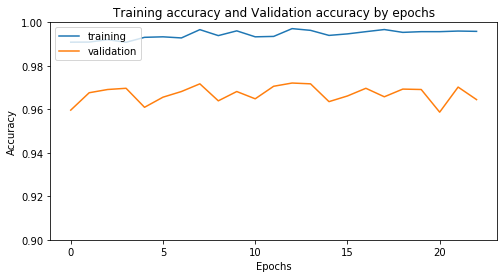

In [316]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [317]:
test_accuracy = model_fc_o.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 45us/step


In [318]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes)", "Test accuracy": test_accuracy }, ignore_index = True)

In [319]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708
1,Shallow NN,0.884673
2,"NN 2 HL,5 nodes",0.875595
3,"NN 2 HL,16 nodes",0.939435
4,"Opimized NN (3 HL, 128 nodes)",0.966369
5,"Opimized NN (3 HL, 128 nodes)",0.966369


Observations:
- Bayes error : 0 (Humans can perfectly identify)
- Training error : 0.004
- Test accuracy: 0.037

We have successfully reduced the bias but there is varaince now due to overfitting.Variance can be decreased by:
- l2 Regularization 
- Drop out regularization

## Regulazrization 

### Dropout and Regularization

In [323]:
model_fc_r = Sequential()
model_fc_r.add(Dense(128, input_shape = (784,), activation = "tanh"))
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(128, activation = "tanh"))
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(128, activation = "tanh"))
model_fc_r.add(Dropout(0.2))
model_fc_r.add(Dense(10, activation = "softmax"))

In [325]:
model_fc_r.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [326]:
history = model_fc_r.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 6s 296us/step - loss: 0.4582 - accuracy: 0.8585 - val_loss: 0.2605 - val_accuracy: 0.9185
Epoch 2/100
21504/21504 [==============================] - 6s 256us/step - loss: 0.2690 - accuracy: 0.9180 - val_loss: 0.2187 - val_accuracy: 0.9358
Epoch 3/100
21504/21504 [==============================] - 7s 318us/step - loss: 0.2127 - accuracy: 0.9343 - val_loss: 0.1767 - val_accuracy: 0.9451
Epoch 4/100
21504/21504 [==============================] - 6s 301us/step - loss: 0.1800 - accuracy: 0.9433 - val_loss: 0.1527 - val_accuracy: 0.9542
Epoch 5/100
21504/21504 [==============================] - 5s 230us/step - loss: 0.1534 - accuracy: 0.9515 - val_loss: 0.1511 - val_accuracy: 0.9554
Epoch 6/100
21504/21504 [==============================] - 8s 351us/step - loss: 0.1353 - accuracy: 0.9581 - val_loss: 0.1490 - val_accuracy: 0.9572
Epoch 7/100
21504/21504 [==============================] 

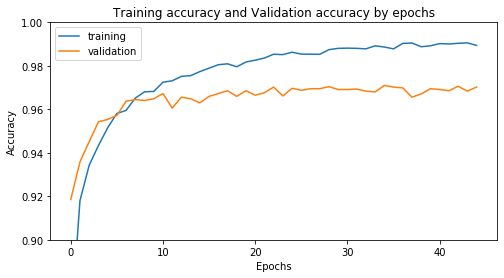

In [327]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [328]:
test_accuracy = model_fc_r.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 48us/step


In [331]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes) with Dropout", "Test accuracy": test_accuracy }, ignore_index = True)

In [345]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708
1,Shallow NN,0.884673
2,"NN 2 HL,5 nodes",0.875595
3,"NN 2 HL,16 nodes",0.939435
4,"Opimized NN (3 HL, 128 nodes)",0.966369
5,"Opimized NN (3 HL, 128 nodes) with Dropout",0.968452


Observation: <br>
 We reduce the variance but not much. Furthermure we can combine both drop out and l2 regularization

### Dropout

In [320]:
RS_CV.best_params_

{'optimizer': 'adam', 'nodes': 128, 'hl': 3, 'activation': 'tanh'}

In [ ]:
 activity_regularizer=regularizers.l1(0.01)))

In [354]:
model_fc_r2 = Sequential()
model_fc_r2.add(Dense(128, input_shape = (784,), activation = "tanh", activity_regularizer = regularizers.l2(0.00001)))
model_fc_r2.add(Dropout(0.2))
model_fc_r2.add(Dense(128, activation = "tanh", activity_regularizer = regularizers.l2(0.00001)))
model_fc_r2.add(Dropout(0.2))
model_fc_r2.add(Dense(128, activation = "tanh", activity_regularizer = regularizers.l2(0.00001)))
model_fc_r2.add(Dropout(0.2))
model_fc_r2.add(Dense(10, activation = "softmax"))

In [355]:
model_fc_r2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [363]:
history = model_fc_r2.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping])

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 9s 416us/step - loss: 0.1172 - accuracy: 0.9929 - val_loss: 0.2671 - val_accuracy: 0.9701
Epoch 2/100
21504/21504 [==============================] - 8s 366us/step - loss: 0.1162 - accuracy: 0.9927 - val_loss: 0.2710 - val_accuracy: 0.9678
Epoch 3/100
21504/21504 [==============================] - 4s 175us/step - loss: 0.1159 - accuracy: 0.9934 - val_loss: 0.2723 - val_accuracy: 0.9684
Epoch 4/100
21504/21504 [==============================] - 4s 199us/step - loss: 0.1114 - accuracy: 0.9941 - val_loss: 0.2811 - val_accuracy: 0.9697
Epoch 5/100
21504/21504 [==============================] - 6s 267us/step - loss: 0.1178 - accuracy: 0.9926 - val_loss: 0.2733 - val_accuracy: 0.9678
Epoch 6/100
21504/21504 [==============================] - 5s 229us/step - loss: 0.1142 - accuracy: 0.9934 - val_loss: 0.2621 - val_accuracy: 0.9699
Epoch 7/100
21504/21504 [==============================] 

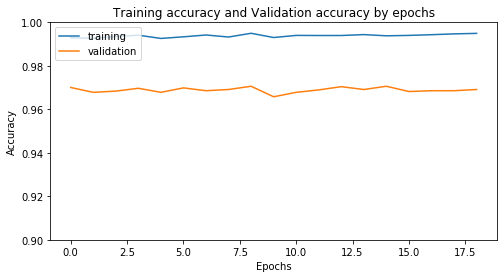

In [364]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.9,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [359]:
test_accuracy = model_fc_r2.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 66us/step


In [360]:
Summary_table  = Summary_table.append({"model": "Opimized NN (3 HL, 128 nodes) with Dropout & L2", "Test accuracy": test_accuracy }, ignore_index = True)

In [361]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708
1,Shallow NN,0.884673
2,"NN 2 HL,5 nodes",0.875595
3,"NN 2 HL,16 nodes",0.939435
4,"Opimized NN (3 HL, 128 nodes)",0.966369
5,"Opimized NN (3 HL, 128 nodes) with Dropout",0.968452
6,"Opimized NN (3 HL, 128 nodes) with Dropout & L2",0.968750
